### 温度预测的问题

数据集包含 14 个维度不同的数据，其中包含气温，这里准备使用其他的维度来执行温度的预测。

In [2]:
import os

data_dir = '/users/haoxingxiao/academic/data/jena_climate'
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')

f = open(fname)
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420551


将 42W 行数据转换成 Numpy 数组：

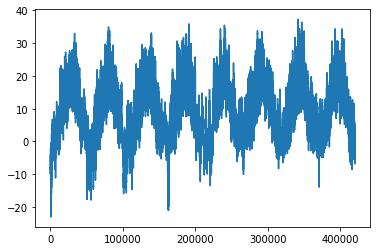

In [3]:
import numpy as np

float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values

from matplotlib import pyplot as plt

# 获取温度
temp = float_data[:, 1] 
plt.plot(range(len(temp)), temp)

从上图可以明显看出温度的周期性变化。
每过 10 分钟进行一次记录，所以每天有 144 个数据，看前 10 天的数据：

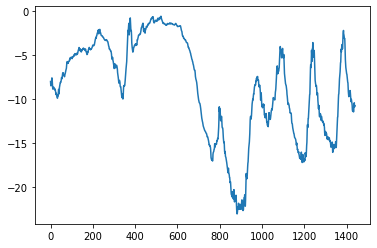

In [4]:
plt.plot(range(1440), temp[:1440])

准备数据：

|变量|数值|描述|
|--|-|---|
|lookback|720|给定过去 5 天的数据|
|steps|6|每小时一个数据点|
|delay|144|执行预测的是未来 24 小时的数据|

In [5]:
mean = float_data[:200000].mean(axis=0)
float_data -=mean
std = float_data[:200000].std(axis=0)
float_data /= std

In [ ]:
def plot_loss(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(loss))

    plt.figure()

    plt.plot(epochs, loss[1:], 'bo', label='Traning loss')
    plt.plot(epochs, val_loss[1:], 'b', label='Validation loss')
    plt.title('Traning and validation loss')
    plt.legend()

    plt.show()

得到的是 [-1, 1]范围的数据。
继续创建函数，批量生成数据的生成器：

In [6]:
def generator(data, lookback, delay, min_index, max_index, shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index=len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(min_index + lookback, max_index, batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)
        
        samples = np.zeros((len(rows), lookback // step, data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets
        
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data, lookback=lookback, delay=delay, min_index=0, max_index=200000, shuffle=True, step=step, batch_size=batch_size)
val_gen = generator(float_data, lookback=lookback, delay=delay, min_index=200001, max_index=300000, shuffle=True, step=step, batch_size=batch_size)
test_gen = generator(float_data, lookback=lookback, delay=delay, min_index=300001, max_index=None, shuffle=True, step=step, batch_size=batch_size)

# 验证集的循环次数
val_steps = (300000 - 200001 - lookback) // batch_size

# 测试集的循环次数
test_steps = (len(float_data) - 300001 - lookback) // batch_size

使用一种基准方法：24h 后的温度等于现在的温度。现在计算该方法的准确性。
<br />
直接定义：明天 9 点的温度和今天 9 点的就是一样的。这种方式不考虑任何变化因素，可以理解为一种”最差的“预测方案了，我们的预测准确性是以此为基准进行的，不会比这个差了。

In [7]:
def evaluate_naive_method():
    batch_maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    print(np.mean(batch_maes))
    
evaluate_naive_method()

0.2889088953195082


In [8]:
celsius_mae = 0.29 * std[1]
print(celsius_mae)

2.5672247338393395


平均误差是 2.56°C，误差还是挺大的。

下面使用一种密集连接层的方式实现基础的 ML 方法：

In [9]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, float_data.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen, steps_per_epoch=500, epochs=20, validation_data=val_gen, validation_steps=val_steps)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/20
500/500 [==============================] - 11s 23ms/step - loss: 1.3185 - val_loss: 0.6162
Epoch 2/20
500/500 [==============================] - 11s 23ms/step - loss: 0.4276 - val_loss: 0.3265
Epoch 3/20
500/500 [==============================] - 12s 23ms/step - loss: 0.2937 - val_loss: 0.3000
Epoch 4/20
500/500 [==============================] - 12s 24ms/step - loss: 0.2659 - val_loss: 0.3151
Epoch 5/20
500/500 [==============================] - 12s 23ms/step - loss: 0.2507 - val_loss: 0.3154
Epoch 6/20
500/500 [==============================] - 12s 24ms/step - loss: 0.2417 - val_loss: 0.3356
Epoch 7/20
500/500 [==============================] - 12s 23ms/step - loss: 0.2351 - val_loss: 0.3348
Epoch 8/20
500/500 [==============================] - 13s 25ms/step - loss: 0.2289 - val_loss: 0.3198
Epoch 9/20
500/500 [==============================] - 13s 26ms/step - loss: 0.2225 - val_loss: 0.3372
Epoch 

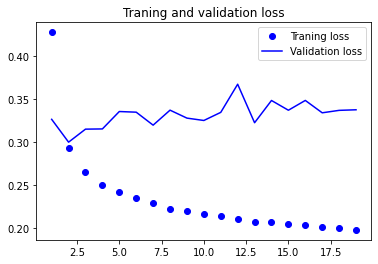

In [11]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss))

plt.figure()

plt.plot(epochs, loss[1:], 'bo', label='Traning loss')
plt.plot(epochs, val_loss[1:], 'b', label='Validation loss')
plt.title('Traning and validation loss')
plt.legend()

plt.show()

使用简单的密集连接网络在温度预测问题上的训练损失和验证损失都不低。why？我们使用了一个两层的网络空间去解决这个问题。<b>在复杂的空间寻找简单问题的解决方案，可能无法学习到简单的基准方法。</b>


使用 GRU 层进行计算，相较LSTM 更简单，代价更低，是一种<b>计算代价与表示能力的折中</b>。

In [15]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen, steps_per_epoch=500, epochs=20, validation_data=val_gen, validation_steps=val_steps)


Epoch 1/20
500/500 [==============================] - 62s 124ms/step - loss: 0.3025 - val_loss: 0.2711
Epoch 2/20
500/500 [==============================] - 60s 120ms/step - loss: 0.2868 - val_loss: 0.2639
Epoch 3/20
500/500 [==============================] - 57s 114ms/step - loss: 0.2783 - val_loss: 0.2641
Epoch 4/20
500/500 [==============================] - 56s 112ms/step - loss: 0.2750 - val_loss: 0.2638
Epoch 5/20
500/500 [==============================] - 57s 113ms/step - loss: 0.2702 - val_loss: 0.2609
Epoch 6/20
500/500 [==============================] - 55s 110ms/step - loss: 0.2653 - val_loss: 0.2582
Epoch 7/20
500/500 [==============================] - 55s 110ms/step - loss: 0.2585 - val_loss: 0.2640
Epoch 8/20
500/500 [==============================] - 56s 113ms/step - loss: 0.2552 - val_loss: 0.2694
Epoch 9/20
500/500 [==============================] - 55s 110ms/step - loss: 0.2500 - val_loss: 0.2775
Epoch 10/20
500/500 [==============================] - 53s 106ms/step - l

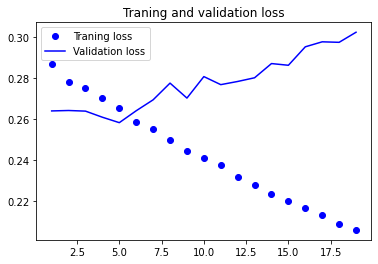

In [16]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss))

plt.figure()

plt.plot(epochs, loss[1:], 'bo', label='Traning loss')
plt.plot(epochs, val_loss[1:], 'b', label='Validation loss')
plt.title('Traning and validation loss')
plt.legend()

plt.show()

新的 MAE 误差约 0.265，转换成标准温度差约为 2.35°C，好一点了。但是很快就达到了过拟合了。

## 使用 dropout 降低过拟合

将某一层的输入单元随机设为 0，打破该层训练数据的偶然相关性。
<br />
但是如何选择合适的 dropout 不是一个容易的事情，在循环网络中正确的方式应该是：<b>在每个时间步中应该是用相同的 dropout 掩码(dropout mask)，而不是让掩码随着时间步的增加而随机变化。</b>此外，为了对 GRU，LSTM 等循环层做正则化，应该将不随着时间变化的 dropout 掩码应用于层的内部循环激活，称为循环 dropout 掩码。

2 个参数：1.dropout，指定输入单元的丢弃比例。2. recurrent_dropout，指定循环单元的丢弃比例。

 * 由于 dropout 需要更长时间才能收敛，epoch 增加为原来的两倍。

In [ ]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32, dropout=0.2, recurrent_dropout=0.2, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')

history = model.fit_generator(train_gen, steps_per_epoch=500, epochs=40, validation_data=val_gen, validation_steps=val_steps)


Epoch 1/40
500/500 [==============================] - 86s 173ms/step - loss: 0.3231 - val_loss: 0.2770
Epoch 2/40
500/500 [==============================] - 93s 186ms/step - loss: 0.3042 - val_loss: 0.2777
Epoch 3/40
500/500 [==============================] - 87s 175ms/step - loss: 0.2961 - val_loss: 0.2733
Epoch 4/40
500/500 [==============================] - 87s 174ms/step - loss: 0.2918 - val_loss: 0.2671
Epoch 5/40
500/500 [==============================] - 86s 172ms/step - loss: 0.2869 - val_loss: 0.2686
Epoch 6/40
427/500 [========================>.....] - ETA: 10s - loss: 0.2853

In [ ]:
plot_loss(history)

## 循环层堆叠

